### Machine Learning Emulation of Timeseries Antenatal Care Data 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import time
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
print(torch.__version__)

2.6.0+cu124


In [3]:
# Set seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)
random.seed(2)

In [4]:
print("Is CUDA available? ", torch.cuda.is_available())
print("GPU count: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

Is CUDA available?  True
GPU count:  8
GPU Name:  NVIDIA RTX A5000


### Data

In [5]:
from src.preprocessing import process_dataframe

In [6]:
# Load and process data
df = pd.read_csv("data/sim_compendia_train/runs/ANC_Simulation_25000_runs.csv", index_col=0).reset_index(drop=True)
#df = df[(df['t'] >= 3650) & (df['t'] <= 7320)]
df = process_dataframe(df)
df.head()

,run,t,prev_true,EIR_true,vol_true,tested,positive,incall
0,1.0,720.0,0.491898,31.239739,0.3,216.666667,75.416667,0.005069
1,1.0,1800.0,0.150356,0.816613,0.3,209.500000,22.166667,0.000169
2,1.0,2880.0,0.113505,0.932209,0.3,220.166667,18.583333,0.000308
3,1.0,3660.0,0.202485,3.776952,0.3,246.000000,54.000000,0.000787
4,1.0,3690.0,0.193039,2.468473,0.3,247.000000,51.000000,0.000518


### Exploratory Data Analysis

In [7]:
from src.util import plot_subplots_for_runs

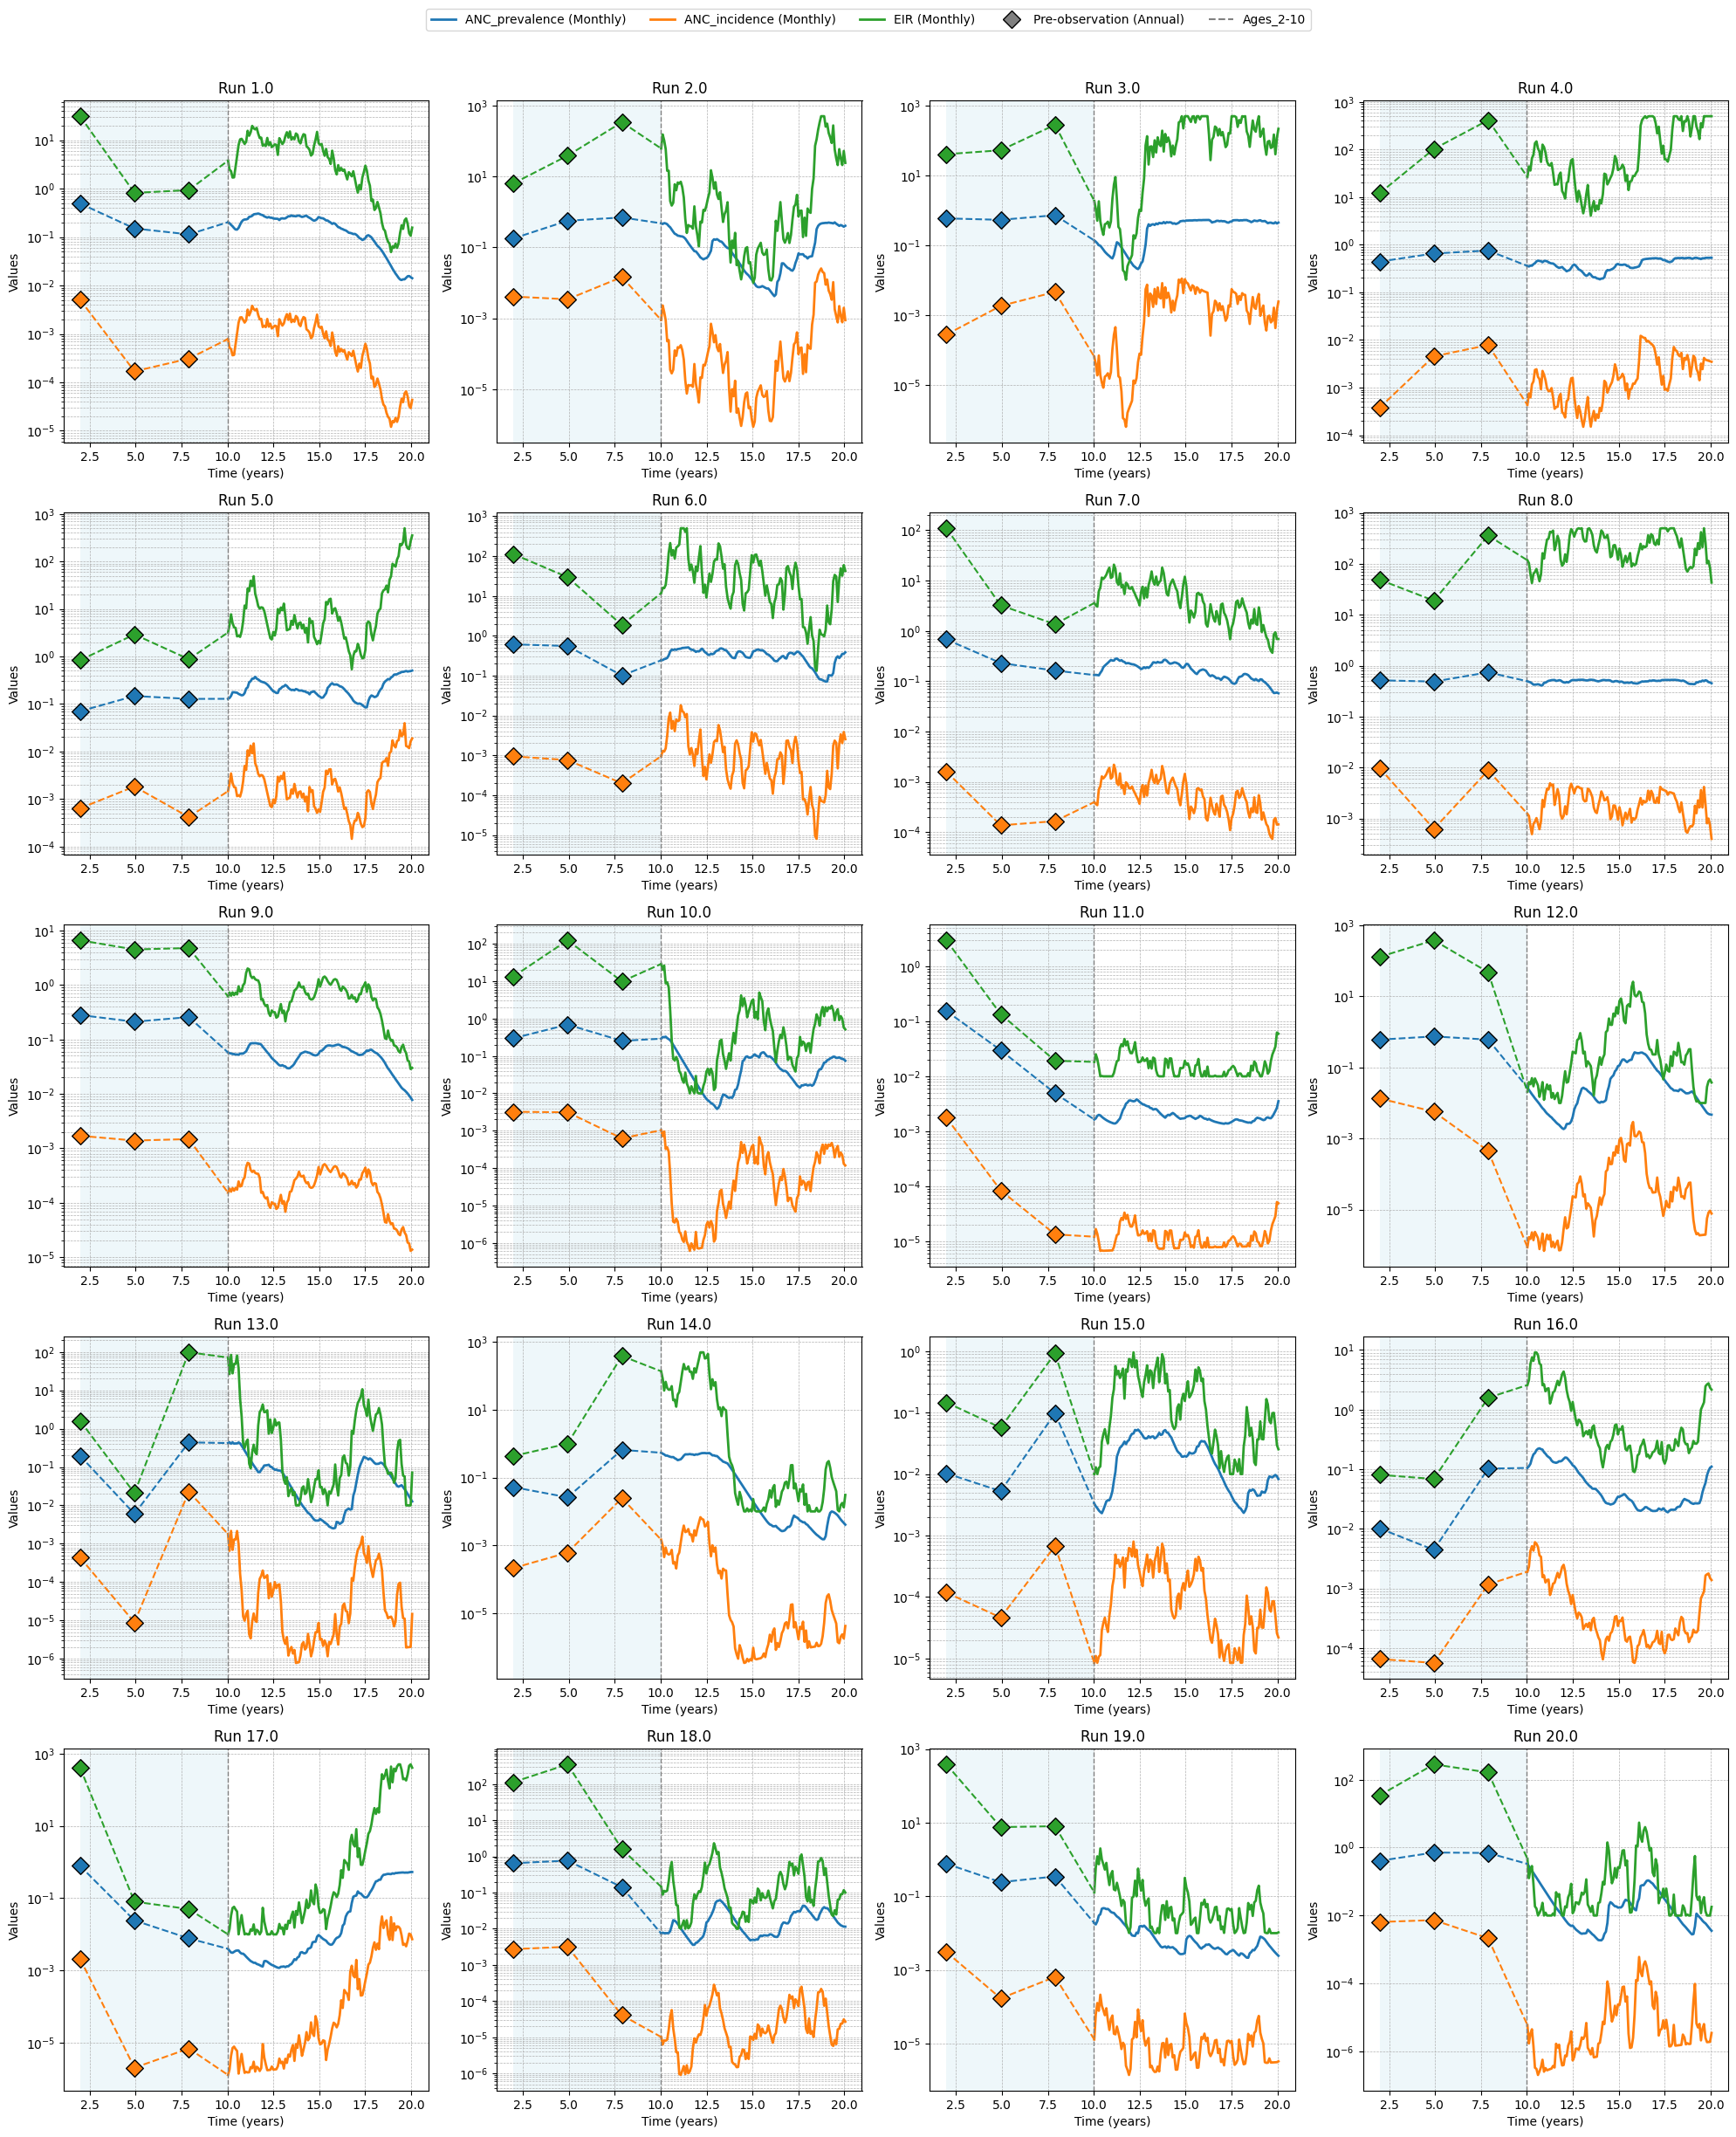

In [8]:
plot_subplots_for_runs(df, num_runs=20)


In [9]:
#Cross Correlation
from src.util import plot_cross_correlation

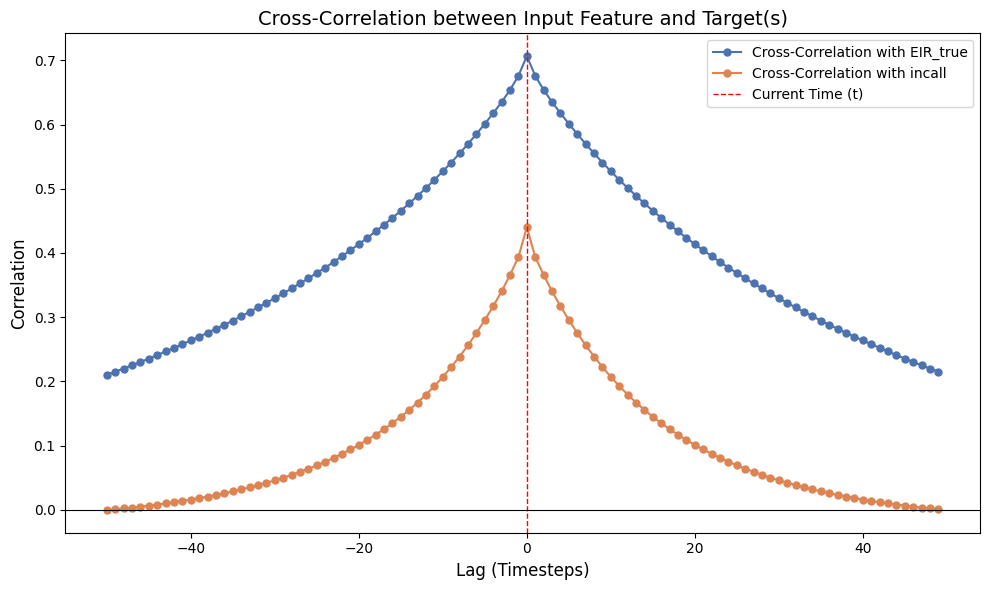

In [10]:
plot_cross_correlation(df, 'prev_true', ['EIR_true', 'incall'])

## Preprocessing - Feature Engineering

In [11]:
from src.sequence_creator import create_sequences

In [12]:
train_data = df[df['run'] <= 24000]
eval_data = df[(df['run'] > 24000) & (df['run'] <= 24700)]
test_data = df[df['run'] > 24700]
cols_to_transform = ["prev_true", "EIR_true", "incall"]
log_transform = lambda x: np.log(x + 1e-8)  # Avoids log(0) errors

In [13]:
train_data_scaled = train_data.copy()
eval_data_scaled = eval_data.copy()
test_data_scaled = test_data.copy()
for col in cols_to_transform:
    train_data_scaled[col] = log_transform(train_data_scaled[col])
    eval_data_scaled[col] = log_transform(eval_data_scaled[col])
    test_data_scaled[col] = log_transform(test_data_scaled[col])

In [15]:
#Specifying size inspired by cross-correlation
window_size = 10

#Creating sequences of tensors
X_train, y_train = create_sequences(train_data_scaled, window_size)
X_eval, y_eval = create_sequences(eval_data_scaled, window_size)

In [13]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
eval_dataset = torch.utils.data.TensorDataset(X_eval, y_eval)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [14]:
X_train.shape

torch.Size([2951990, 21])

### Model Architecture and Training

In [12]:
from src.model_exp import LSTMModel, train_model

In [15]:
architectures = {
    "2_layers": [128, 64],
    "3_layers": [200, 100, 50],
    "4_layers": [256, 128, 64, 32],
    "5_layers": [300, 200, 100, 50, 25]
    #"6_layers": [512, 256, 128, 64, 32]
}

In [16]:
results = []
for name, architecture in architectures.items():
    print(f"Training model: {name}")
    model = LSTMModel(input_size=1, architecture=architecture)
    trained_model, loss_history, eval_loss_history, duration = train_model(model, train_loader, eval_loader, model_name=name)
    results.append({
        "name": name,
        "model": trained_model,
        "loss_history": loss_history,
        "eval_loss_history": eval_loss_history,
        "duration": duration
    })
print("Training complete!")


Training model: 2_layers
Epoch 1/25, Loss: 0.3458, Eval Loss: 0.2190
Epoch 2/25, Loss: 0.1646, Eval Loss: 0.1592
Epoch 3/25, Loss: 0.1533, Eval Loss: 0.1594
Epoch 4/25, Loss: 0.1480, Eval Loss: 0.1499
Epoch 5/25, Loss: 0.1437, Eval Loss: 0.1584
Epoch 6/25, Loss: 0.1405, Eval Loss: 0.1461
Epoch 7/25, Loss: 0.1380, Eval Loss: 0.1422
Epoch 8/25, Loss: 0.1356, Eval Loss: 0.1511
Epoch 9/25, Loss: 0.1335, Eval Loss: 0.1400
Epoch 10/25, Loss: 0.1321, Eval Loss: 0.1384
Epoch 11/25, Loss: 0.1304, Eval Loss: 0.1358
Epoch 12/25, Loss: 0.1294, Eval Loss: 0.1384
Epoch 13/25, Loss: 0.1281, Eval Loss: 0.1351
Epoch 14/25, Loss: 0.1271, Eval Loss: 0.1346
Epoch 15/25, Loss: 0.1263, Eval Loss: 0.1359
Epoch 16/25, Loss: 0.1255, Eval Loss: 0.1358
Epoch 17/25, Loss: 0.1248, Eval Loss: 0.1352
Epoch 18/25, Loss: 0.1243, Eval Loss: 0.1344
Epoch 19/25, Loss: 0.1237, Eval Loss: 0.1325
Epoch 20/25, Loss: 0.1232, Eval Loss: 0.1408
Epoch 21/25, Loss: 0.1234, Eval Loss: 0.1368
Epoch 22/25, Loss: 0.1223, Eval Loss: 0

### Model Evaluation

In [1]:
from src.util import plot_training_metrics

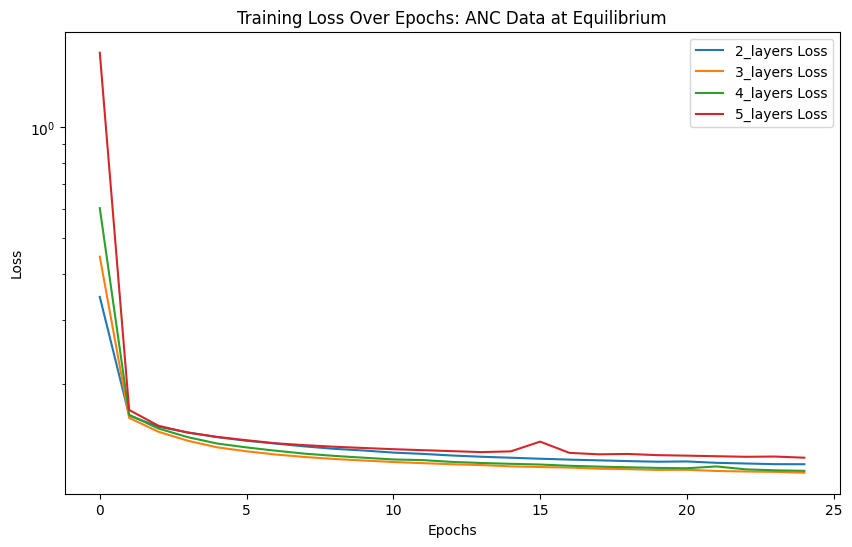

In [17]:
#Plot loss function
plot_training_metrics(results)

In [ ]:
from src.util import plot_model_comparison

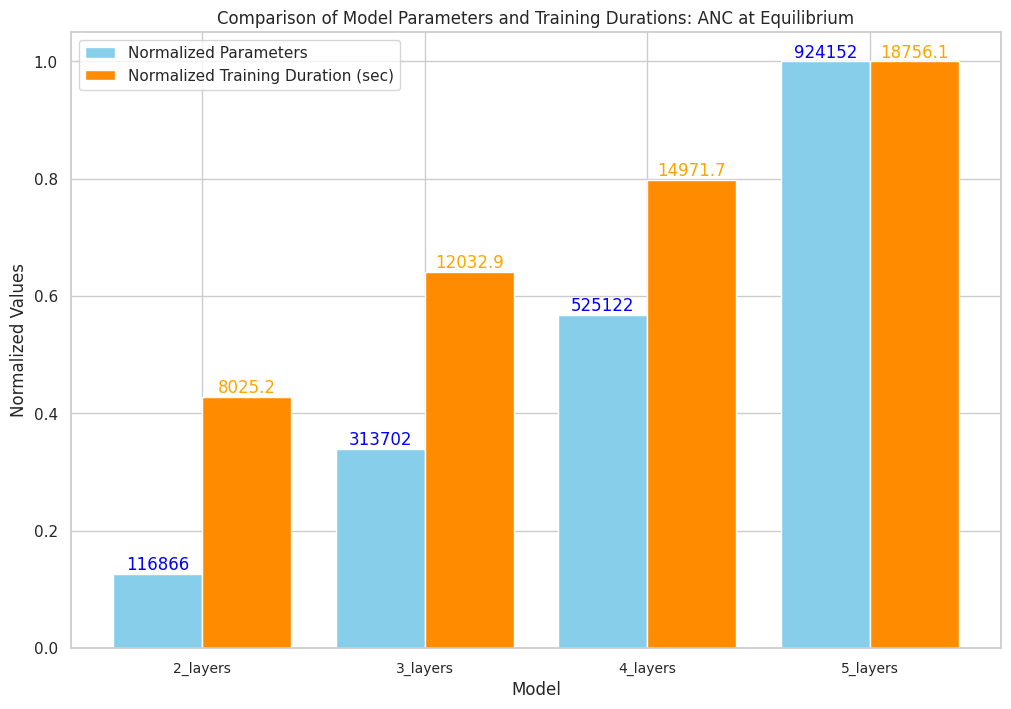

In [18]:
#Plot model parameters and training duration
plot_model_comparison(results)

### Model Evaluation and Inferencing

In [ ]:
from src.evaluate import predict_in_batches, plot_performance_metrics

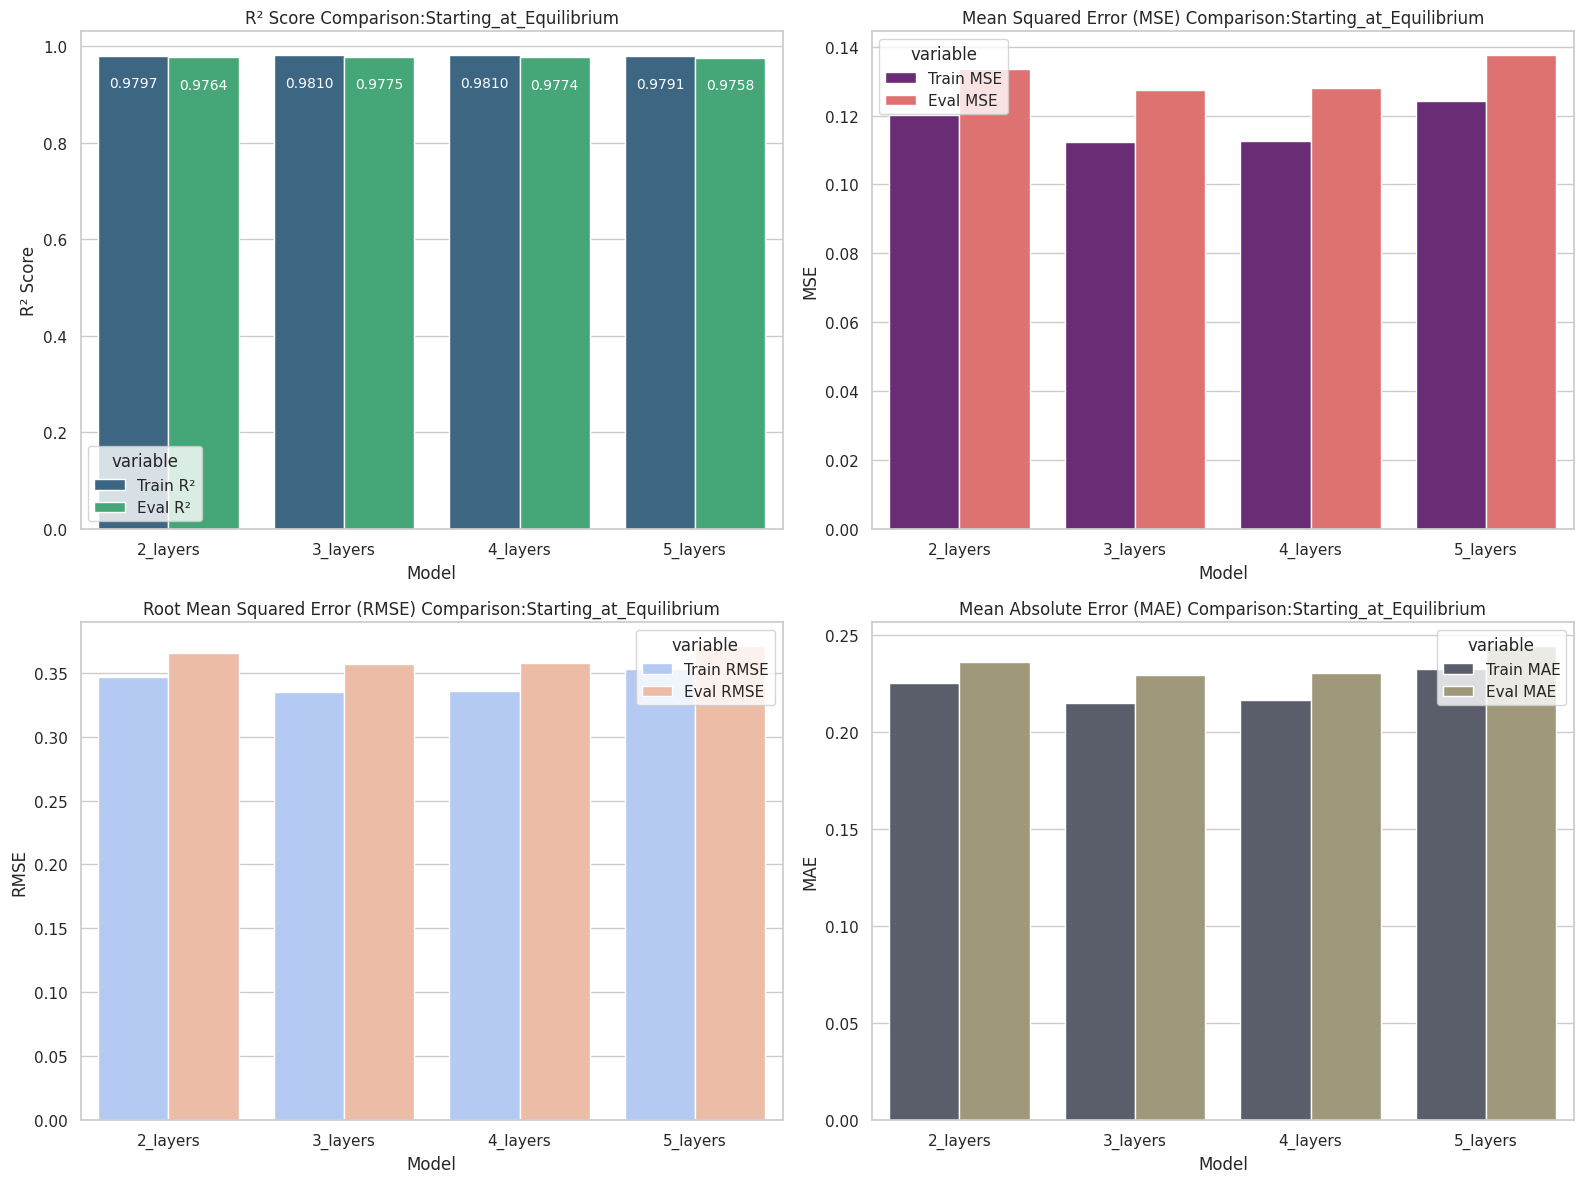

In [20]:
#Compare Model Performance across train models
plot_performance_metrics(results, X_train, y_train, X_eval, y_eval)

### Inference on Test Set

In [9]:
from src.inference import test_model

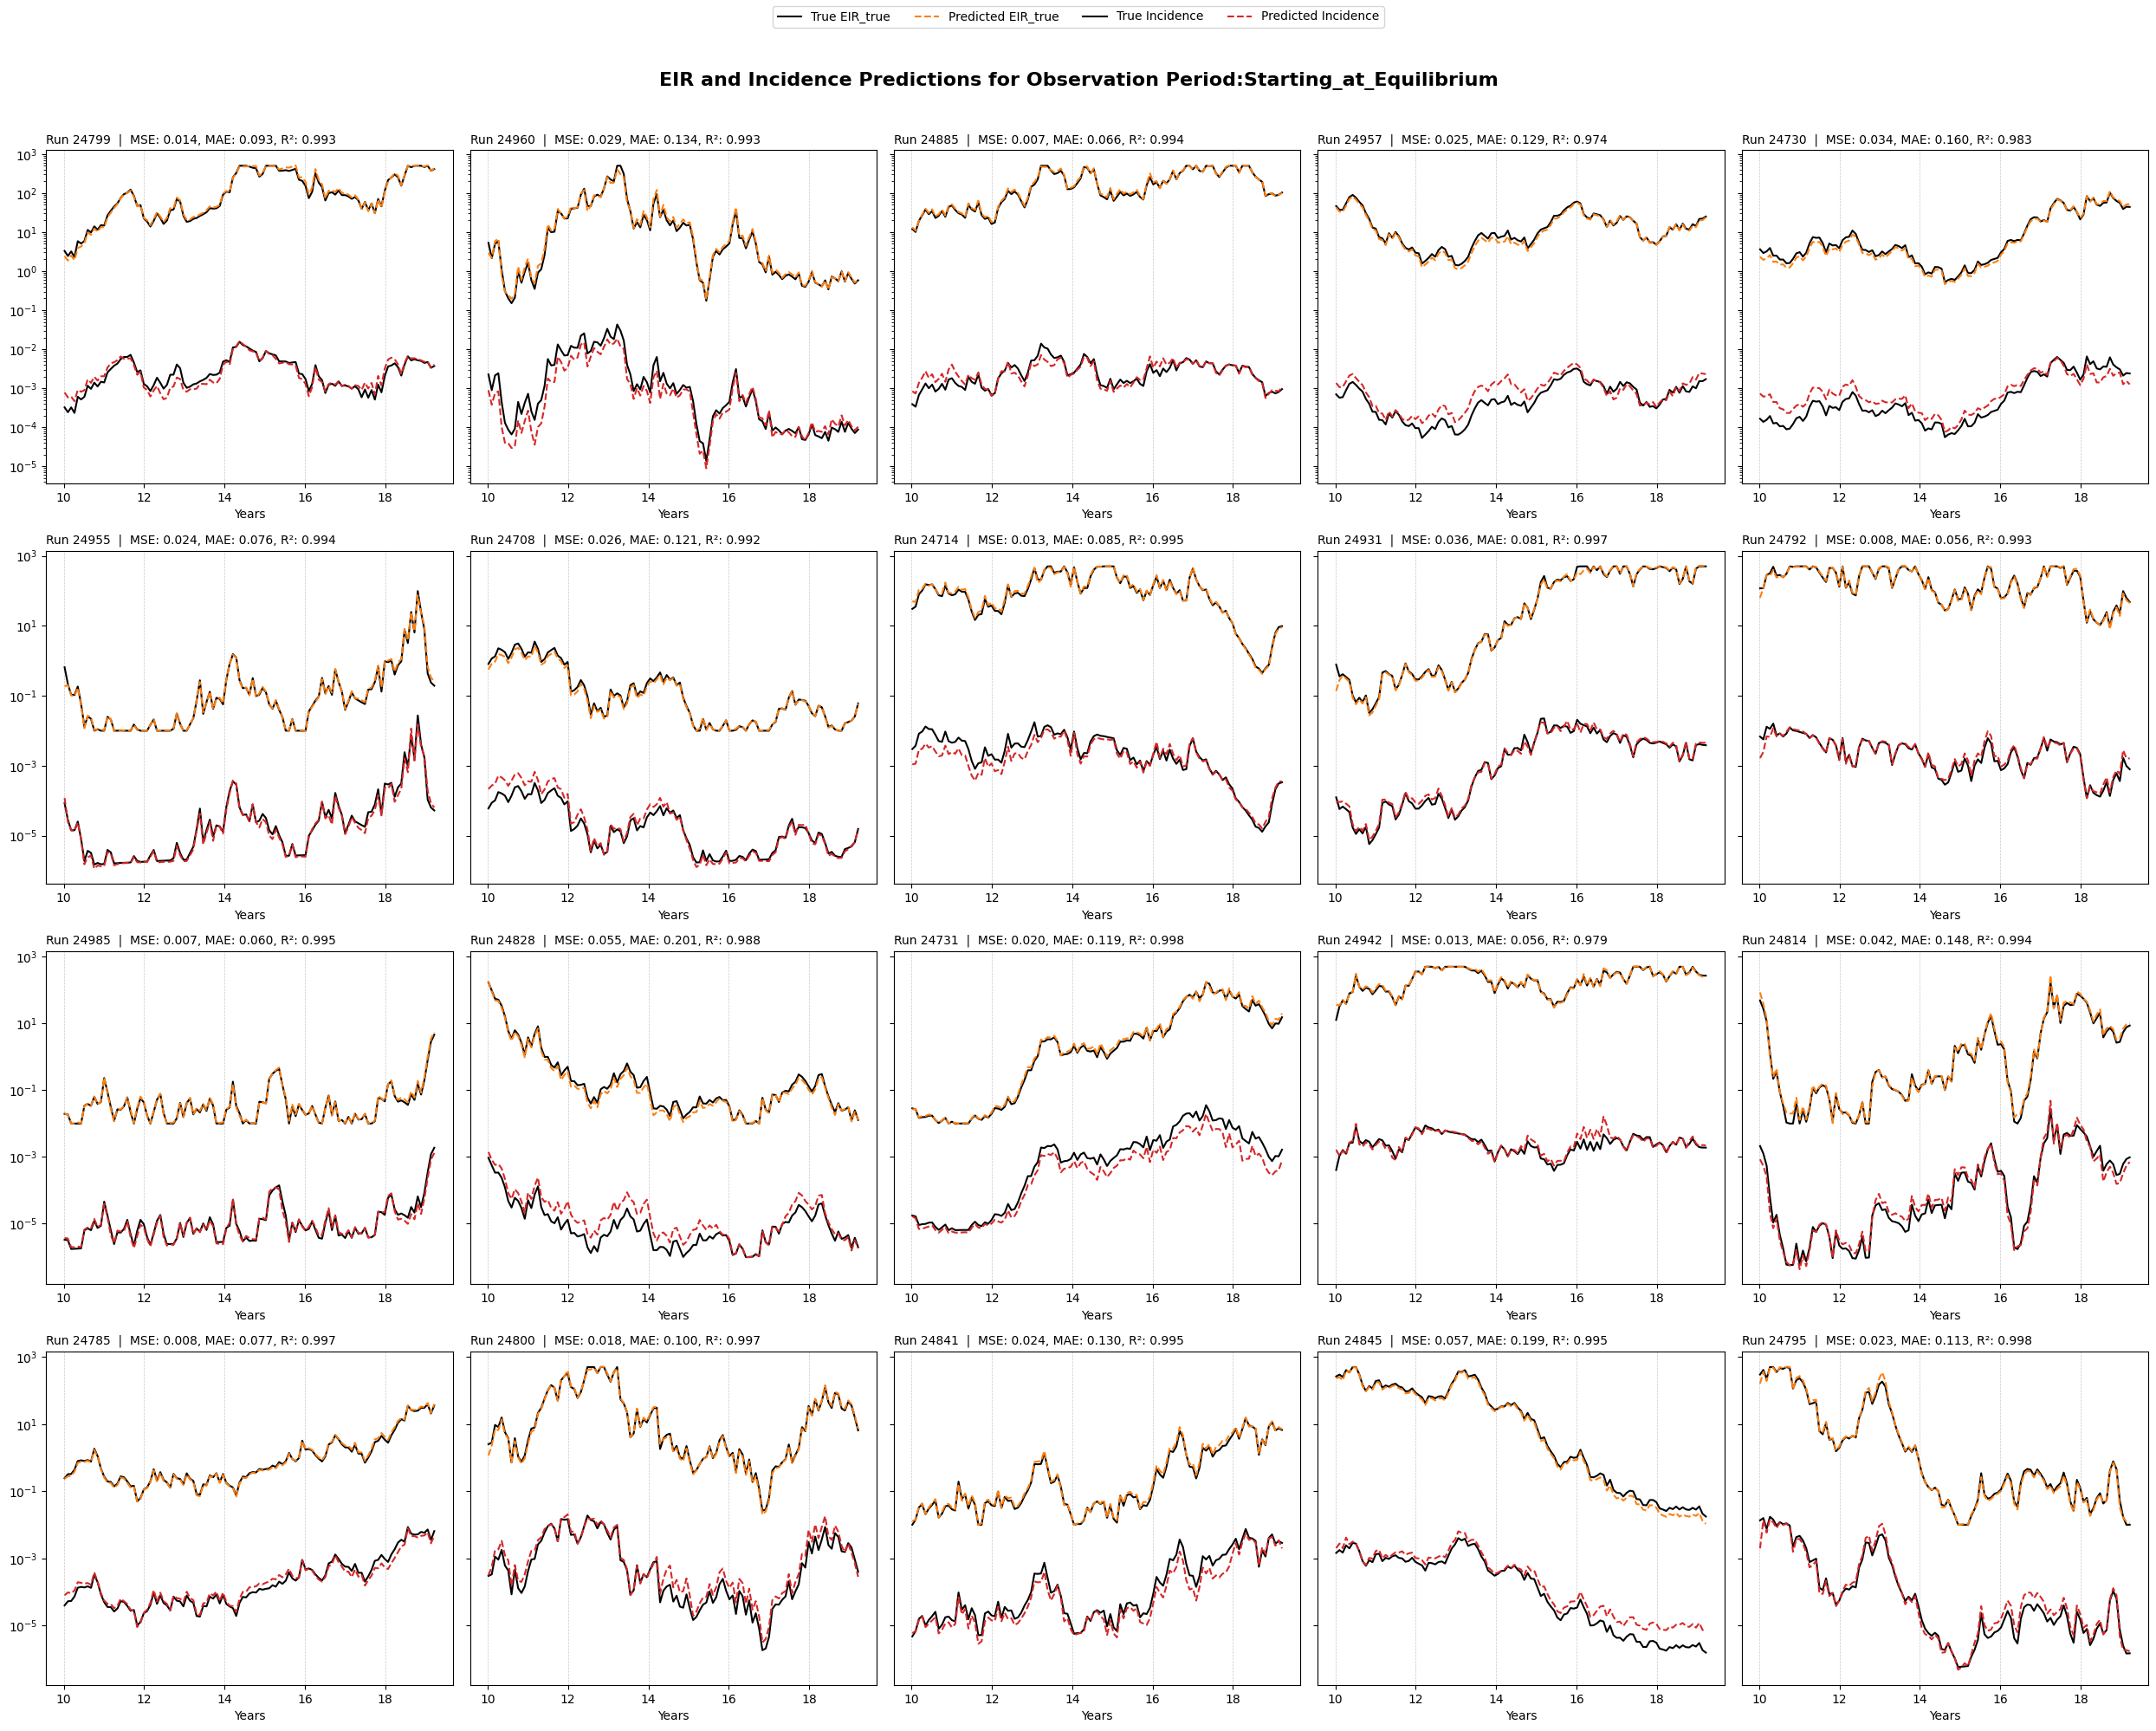

In [12]:
test_model("src/trained_model/4_layers_model.pth", test_data, window_size=10, num_runs=20)

### Test Metrics Evaluation

In [15]:
from src.test import calculate_metrics, plot_performance_metrics

/tmp/ipykernel_53355/2811940398.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_53355/2811940398.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_53355/2811940398.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


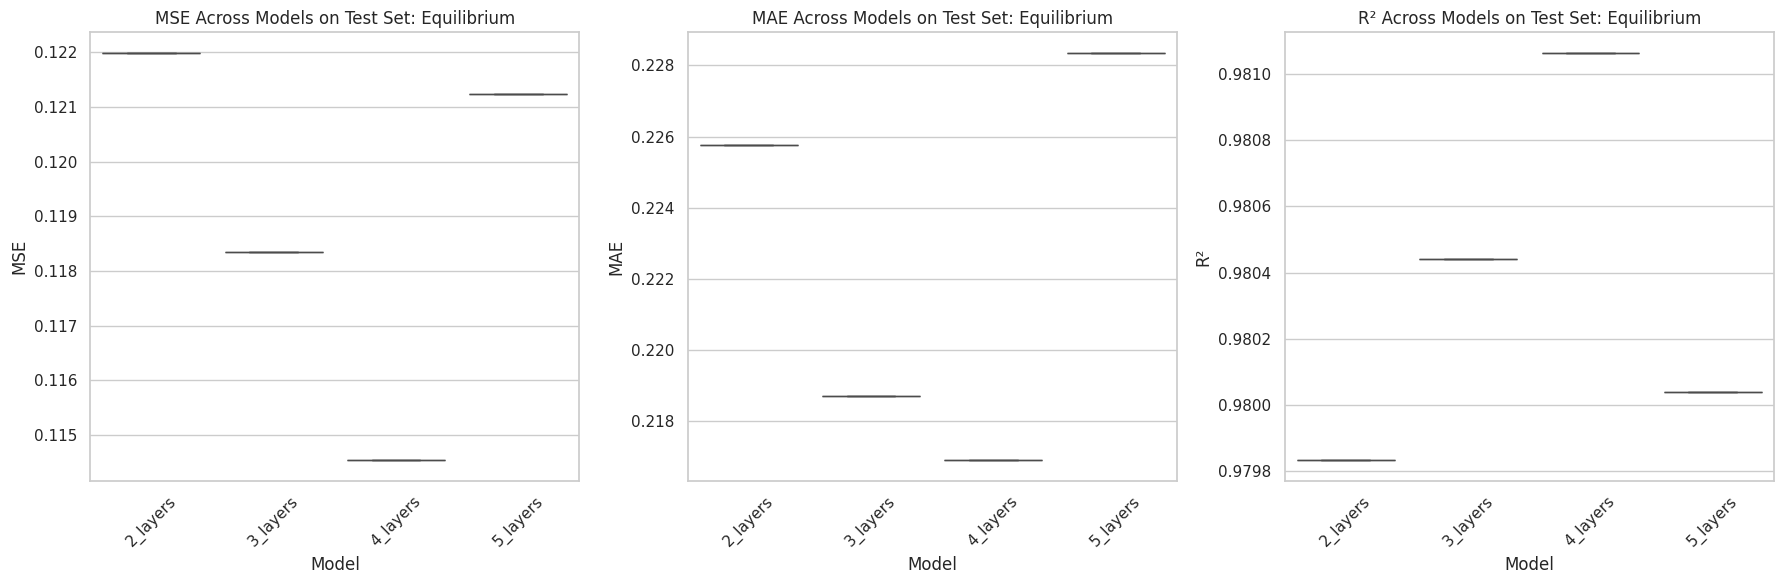

In [25]:
# Define model architectures
model_architectures = {
    "2_layers": [128, 64],
    "3_layers": [200, 100, 50],
    "4_layers": [256, 128, 64, 32],
    "5_layers": [300, 200, 100, 50, 25]
}

# Model paths
model_paths = {
    "2_layers": "src/trained_model/2_layers_model.pth",
    "3_layers": "src/trained_model/3_layers_model.pth",
    "4_layers": "src/trained_model/4_layers_model.pth",
    "5_layers": "src/trained_model/5_layers_model.pth"
}


#  Ploting aggregated Test Metrics
plot_performance_metrics(test_data, window_size=10, model_paths=model_paths)